## Monet Paintings Project

### Introduction to problem and data

In this project we will be taking photos and attempting to convert them to the style of Monet paintings. A bottleneck here is that there is not a 1-1 pairing of photos to Monet's paintings so that our model can extract just the "Monet-ness" of a given image. Instead, we will be looking at using an adversarial network where one model, the generator, is trained to take in a photo and produce a Monet styled equivalent, and another model, the discriminator, will be trained to identify between generated images. The results of the discriminator can then be used as feedback for the generator whether it was able to fool the discriminator or not.

The data provided is 7328 images, all sized 256 x 256. This is split as 300 Monet images and 7028 Photos. These images are provided in two formats, jpg and tfrec, but with tfrec being the recommended format from the data producer. The dataset is already well cleaned, with no blank images.



In [84]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import keras_tuner
import scipy
import random
from tabulate import tabulate

### Exploratory Data Analysis

There is not much data analysis to be done here, the dataset is provided in a good state, so we will just cover the basics. We parse in the tfrec files to a tensorflow dataset, and switch from 0...255 representation to 0...1 representation of an image to help avoid exploding gradients in our models. We do not perform any dataset augmentation intentionally here, as we expect that all images passed in when using this model will be vertical and the full image to be converted, but we will experiment with that later.

We display a few of the sample images and see that the Monets are likely a relatively easy target for an otherwise difficult project, in many ways a slight blur to an image can move it towards the Monet style. Finally we graph the ratio of photos to Monets. Normally this very unbalanced dataset would be an issue, but in our case we will be feeding these images into different models and generated outputs will be used in place of the real Monets.

In [35]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 255)
    image = tf.reshape(image, [*[256,256], 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [36]:
os.getcwd()
notebook_path = os.path.abspath("MonetPaintingsKaggle.ipynb")
monet_tfrec_path = os.path.join(os.path.dirname(notebook_path), "RawImports/monet_tfrec")
photo_data_path = os.path.join(os.path.dirname(notebook_path), "RawImports/photo_tfrec")

monet_files = tf.io.gfile.glob(monet_tfrec_path + '/monet*.tfrec')
photo_files = tf.io.gfile.glob(photo_data_path + '/photo*.tfrec')

monet_data = load_dataset(monet_files)
photo_data = load_dataset(photo_files)

In [37]:
next(iter(photo_data)).shape

TensorShape([256, 256, 3])

2024-10-13 15:59:54.227425: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-13 15:59:54.390419: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


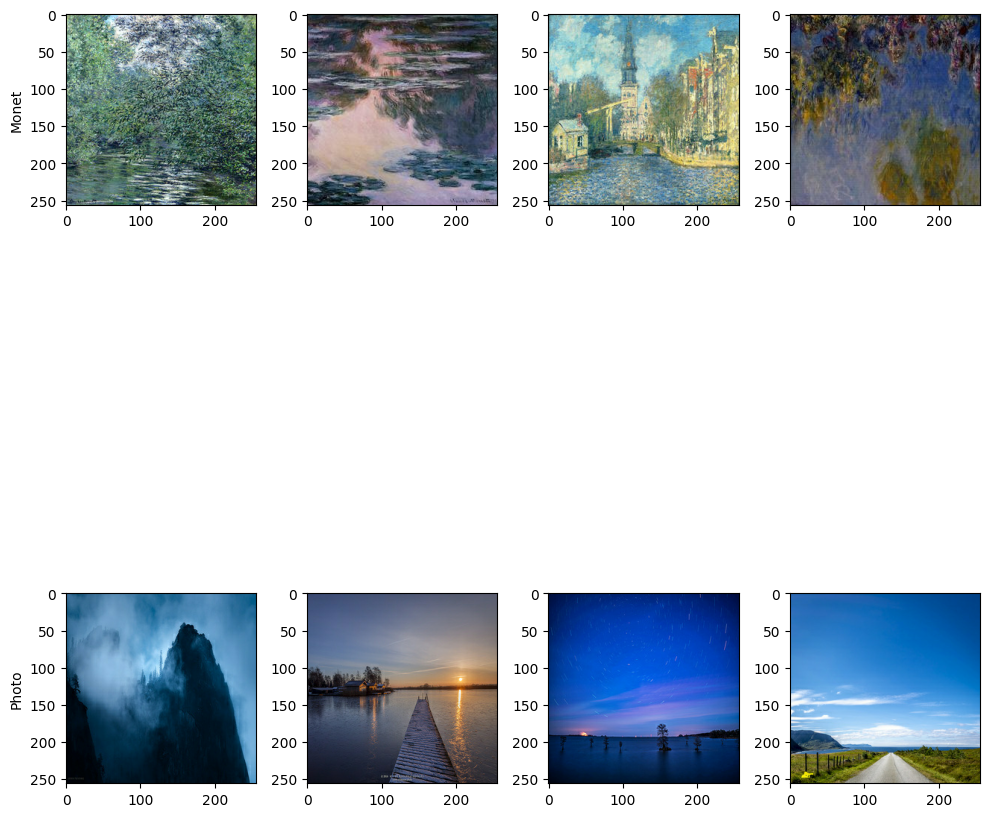

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(10, 15))
for i, monets in enumerate(monet_data.batch(1).take(4)):
    monet = monets[0]
    axs[0, i].imshow(monet)
for i, photos in enumerate(photo_data.batch(1).take(4)):
    photo = photos[0]
    axs[1, i].imshow(photo)
for ax, row in zip(axs[:,0], ['Monet', 'Photo']):
        ax.set_ylabel(row)
fig.tight_layout()
plt.show()

<Axes: >

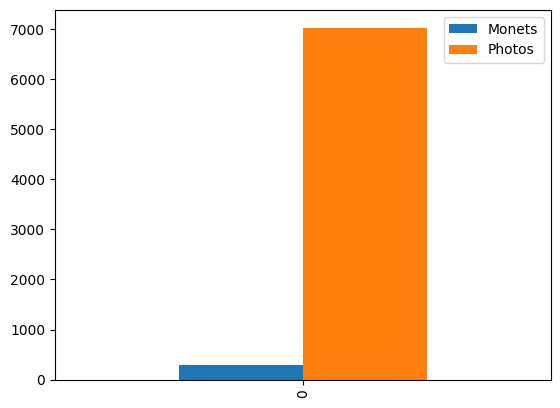

In [42]:
monet_count = monet_data.reduce(np.int64(0), lambda x, _: x + 1).numpy()
photo_count = photo_data.reduce(np.int64(0), lambda x, _: x + 1).numpy()
counts_data = pd.DataFrame({'Monets': [monet_count], 'Photos': [photo_count]})
counts_data.plot(kind="bar")

### Model Architecture

We define a very simple baseline model. Our discriminator is a very standard Convolutional Neural Network with two convolutional layers followed by two dense layers and dropouts. This model could be made much more complex but doing so might actually harm the overall model because the discriminator problem is much simpler than the generator problem, and adversarial networks often see collapse when one model significantly outperforms the other as the generator will get no meaningful feedback if it is always detected.

For the generator our baseline model is testing without being fed an initial image at first, just a vector that can generate a monet from random noise. We then reshape that noise into a 2D image, and use transposed convolutional layers to scale it up from 64x64 to the desired 256x256 (note that the strides of 2 with padding mean we will double the size of the image at each transpose layer) and finally output the size 3 transpose layer to give us an RGB 3 channel representation.

A quick test of the individual models shows that they can handle the data format we expect to pass in, although they of course produce roughly 0.5 values for each entry as they have not yet been trained.

Finally we make the ConditionalGAN class, extending the standard Keras model which first runs the generator on random noise and merges the generated images with an equal set of real Monets. We label these with 0 for the generated images and 1 for real Monets, so we expect our discriminator to output 1 when it identifies a real monet. Calculating gradients and loss on these values lets us train our discriminator.

Next we generate and discriminate a new batch of noise, and this time label all values with 1, indicating that we desire each set of random noise to have tricked the discriminator into marking it as a Monet, and calculate the gradients and losses based on the difference between the discriminator predictions and the all one vector.

In [6]:
baseline_discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((256, 256, 3)),
        keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)

In [7]:
baseline_generator = keras.Sequential(
    [
        keras.layers.InputLayer((256,)),
        keras.layers.Dense(64*64*256),
        keras.layers.Reshape((64, 64, 256)),
        keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="sigmoid"),
    ]
)

In [8]:
baseline_generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1048576)        │   269,484,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,854,595 (1.01 GB)

 Trainable params: 269,854,595 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

In [9]:
baseline_discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    33,554,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,630,209 (128.29 MB)

 Trainable params: 33,630,209 (128.29 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


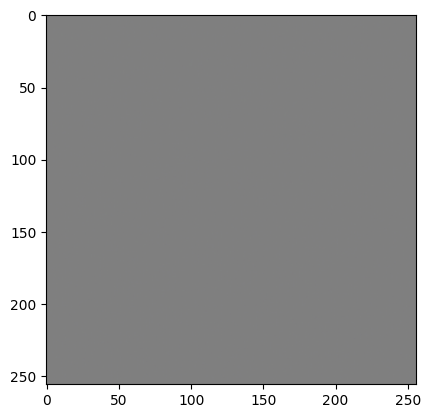

In [10]:
seed = tf.random.normal([1, 256])
sample_prediction = baseline_generator.predict(seed)
plt.imshow(sample_prediction[0, :, :, :])

In [11]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        monets = data
        batch_size = tf.shape(monets)[0]

        photos = tf.random.normal(shape=(batch_size, 256))
        generator_preds = self.generator(photos)

        discriminator_x = tf.concat([generator_preds, monets], axis=0)

        discriminator_y = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        #discriminator_preds = self.discriminator(discriminator_x)
        #generated_preds, real_preds = tf.split(discriminator_preds, 2, 0)

        #discriminator_preds_bool = tf.cast(discriminator_preds, tf.bool)
        #discriminator_y_bool = tf.cast(discriminator_y, tf.bool)
        #discriminator_preds_correct = tf.math.logical_xor(discriminator_preds_bool, discriminator_y_bool)
        #discriminator_preds_correct = tf.math.logical_not(discriminator_preds_correct)
        #discriminator_preds_correct_percentage = tf.reduce_sum(tf.cast(discriminator_preds_correct, tf.int32))/batch_size

        with tf.GradientTape() as tape:
            discriminator_preds = self.discriminator(discriminator_x)
            d_loss = self.loss_fn(discriminator_y, discriminator_preds)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

        photos = tf.random.normal(shape=(batch_size, 256))
        generated_labels = tf.ones((batch_size, 1))
            
        with tf.GradientTape() as tape:
            generated_preds = self.discriminator(self.generator(photos))
            g_loss = self.loss_fn(generated_labels, generated_preds)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )
            
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [12]:
test_gan = ConditionalGAN(baseline_discriminator, baseline_generator)

In [13]:
test_gan.compile(keras.optimizers.Adam(learning_rate=0.001), 
            keras.optimizers.Adam(learning_rate=0.001),
            keras.losses.BinaryCrossentropy())

In [14]:
monet_data = monet_data.repeat()
test_gan.fit(monet_data.take(100), epochs=10)

Epoch 1/10


2024-10-13 08:56:18.407357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/StatefulPartitionedCall/gradient_tape/discriminator_1/leaky_re_lu_1_2/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/StatefulPartitionedCall/discriminator_1/conv2d_1_2/add'.


100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - d_loss: 13.3783 - g_loss: 24.2387
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - d_loss: 3.8463 - g_loss: 17.5173
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - d_loss: 2.3209 - g_loss: 18.9755
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - d_loss: 1.2071 - g_loss: 11.2490
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - d_loss: 0.9576 - g_loss: 2.7666
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - d_loss: 0.5944 - g_loss: 2.4311
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - d_loss: 0.8824 - g_loss: 3.4227
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - d_loss: 0.5717 - g_loss: 2.2436
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - d_loss: 0.5271 - g_loss: 1.9368
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - d_loss: 0.4808 - g_loss: 1.6047


### Results and Analysis

We use the now trained generator on a sample of random noise to generate a new image, and see that this model is falling short. It appears to have chosen a few colors frequently used by Monet images provided and simply scattered them across the image in roughly abstract patterns. We cannot numerically determine how far this is from a Monet without going to Kaggle where the evaluation model is hidden from us, but it is clear this is not the approach we want. Since we have limited submissions to Kaggle we will not even submit this initial attempt.

Instead we define a new generator. Before we were not even using our library of images we have available, so lets start with a photo and try to simply manipulate it into a Monet style instead. Our new generator takes a 256x256 image and first uses convolution layers with stride of 2 to reduce the image scale, losing information about the original, then uses transposed convolutional layers to rebuild the image to the full scale as we did from the random noise before. This way the lost information will have to be re-added by the model allowing us to change the style.

The extension to the Keras Model class needed here is much more complex, and the Keras docs were referenced to build it. This model is known as a Cycle GAN and it needs to make a copy of the generator and the discriminator to be able to go from Monet back to Photo as well.

This allows us to compute a set of loss functions:
1.) Generator Loss for Monet/Photo generator - this loss function is the same as what we had before, computed as a success if the generator fools the respective discriminator

2.) Discriminator Loss for Monet/Photo discriminator - again this loss function is unchanges, although we modified our earlier more complex syntax to be more in line with the Keras docs for readability in the more complex extension. The generator is successful if it assigned a 1 to a real image, or a 0 to a generated image.

3.) Cycle Loss - There is nothing at baseline stopping a cycle GAN from taking an input image and using it as a random seed and ignoring the underlying image, so we define a loss function between the original image and the generated image converted back to the original style, and apply it to all generators to force them to keep changes small and similar to the original image. the Lambda value defines how strict this Loss function is, and recommendations are to keep it between roughly 1-10. Since Monet's style is relatively similar to real images with small scale changes we use the top end of that range.

4.) Identity Loss - Similar to Cycle loss this is a loss to stabilize the images during training. We want an image that is already a Monet to be untransformed, as in an ideal model we would only change the things that are not exclusive to Monet's style (for example we do not want to change all objects in the images to water lillies just because we know they were painted frequently by Monet.) If a car is already in the style of Monet it should have minimal changes. To achieve this we compare a true Monet run through our Monet generator to it's original.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


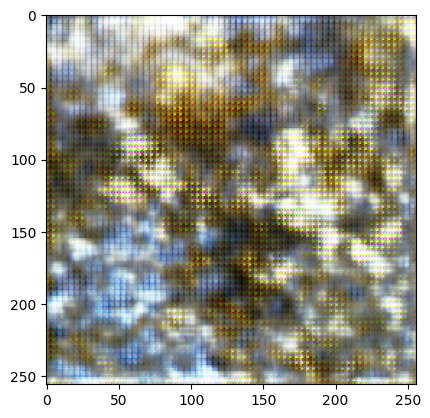

In [15]:
seed = tf.random.normal([1, 256])
sample_prediction = baseline_generator.predict(seed)
plt.imshow(sample_prediction[0, :, :, :])

In [14]:
def getGenerator():
    input_image_generator = keras.Sequential(
        [
            keras.layers.InputLayer((256, 256, 3)),
            keras.layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Dropout(0.2),
            keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Dropout(0.2),
            keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(3, kernel_size=(4, 4), strides=(1, 1), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return input_image_generator

In [15]:
def getDiscriminator():
    input_image_discriminator = keras.Sequential(
        [
            keras.layers.InputLayer((256, 256, 3)),
            keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(64),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation="sigmoid")
        ],
        name="discriminator",
    )
    return input_image_discriminator

In [16]:
# Referenced Keras docs https://keras.io/examples/generative/cyclegan/ for syntax for this class
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        lambda_identity=0.5
    ):
        super(CycleGan, self).__init__()
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
    def compile(
        self,
        monet_generator_optimizer,
        photo_generator_optimizer,
        monet_discriminator_optimizer,
        photo_discriminator_optimizer,
        generator_loss_fn,
        discriminator_loss_fn
    ):
        super(CycleGan, self).compile()
        self.monet_generator_optimizer = monet_generator_optimizer
        self.photo_generator_optimizer = photo_generator_optimizer
        self.monet_discriminator_optimizer = monet_discriminator_optimizer
        self.photo_discriminator_optimizer = photo_discriminator_optimizer
        self.generator_loss_fn = generator_loss_fn
        self.discriminator_loss_fn = discriminator_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.monet_generator(real_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)

            fake_photo = self.photo_generator(real_monet, training=True)
            cycled_monet = self.monet_generator(fake_photo, training=True)

            same_monet = self.monet_generator(real_monet, training=True)
            same_photo = self.photo_generator(real_photo, training=True)

            disc_real_monet = self.monet_discriminator(real_monet, training=True)
            disc_real_photo = self.photo_discriminator(real_photo, training=True)

            disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
            disc_fake_photo = self.photo_discriminator(fake_photo, training=True)

            monet_gen_loss = self.generator_loss_fn(disc_fake_monet)
            photo_gen_loss = self.generator_loss_fn(disc_fake_photo)

            cycle_loss_monet = self.cycle_loss_fn(real_monet, cycled_monet) * self.lambda_cycle
            cycle_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo) * self.lambda_cycle

            identity_loss_monet = self.identity_loss_fn(real_monet, same_monet) * self.lambda_cycle * self.lambda_identity
            identity_loss_photo = self.identity_loss_fn(real_photo, same_photo) * self.lambda_cycle * self.lambda_identity

            total_monet_generator_loss = monet_gen_loss + cycle_loss_monet + cycle_loss_photo + identity_loss_monet
            total_photo_generator_loss = photo_gen_loss + cycle_loss_photo + cycle_loss_monet + identity_loss_photo

            monet_discriminator_loss = self.discriminator_loss_fn(disc_real_monet, disc_fake_monet)
            photo_discriminator_loss = self.discriminator_loss_fn(disc_real_photo, disc_fake_photo)

        # Get the gradients
        monet_generator_gradients = tape.gradient(total_monet_generator_loss, self.monet_generator.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_generator_loss, self.photo_generator.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_discriminator_loss, self.monet_discriminator.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_discriminator_loss, self.photo_discriminator.trainable_variables)

        # Update the weights
        self.monet_generator_optimizer.apply_gradients(zip(monet_generator_gradients, self.monet_generator.trainable_variables))
        self.photo_generator_optimizer.apply_gradients(zip(photo_generator_gradients, self.photo_generator.trainable_variables))
        self.monet_discriminator_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.monet_discriminator.trainable_variables))
        self.photo_discriminator_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.photo_discriminator.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_generator_loss,
            'photo_gen_loss': total_photo_generator_loss,
            'monet_disc_loss': monet_discriminator_loss,
            'photo_disc_loss': photo_discriminator_loss
        }

In [17]:
# Generator loss -- note that BinaryCrossentropy is not the recommended loss function per the documentation,
# however it is the only loss function I could find that did not throw an error due to the loss being interpreted
# as a bool, this is indicated as a possible space for future investigation to resolve that bug
def generator_loss(fake):
    fake_loss = keras.losses.BinaryCrossentropy(reduction=keras.losses.Reduction.NONE)(tf.ones_like(fake), fake)
    return fake_loss

def discriminator_loss(real, fake):
    real_loss = keras.losses.BinaryCrossentropy(reduction=keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    fake_loss = keras.losses.BinaryCrossentropy(reduction=keras.losses.Reduction.NONE)(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

In [43]:
# Generators
monet_generator = getGenerator()
photo_generator = getGenerator()
monet_generator_optimizer = keras.optimizers.Adam(0.0003, beta_1=0.5)
photo_generator_optimizer = keras.optimizers.Adam(0.0003, beta_1=0.5)

# Discriminators
monet_discriminator = getDiscriminator()
photo_discriminator = getDiscriminator()
monet_discriminator_optimizer = keras.optimizers.Adam(0.0003, beta_1=0.5)
photo_discriminator_optimizer = keras.optimizers.Adam(0.0003, beta_1=0.5)

# CycleGan
cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile(monet_generator_optimizer,
                  photo_generator_optimizer,
                  monet_discriminator_optimizer,
                  photo_discriminator_optimizer,
                  generator_loss,
                  discriminator_loss)
    
monet_data_temp = monet_data.shuffle(1024).batch(1)
photo_data_temp = photo_data.shuffle(1024).batch(1)

history = cycle_gan_model.fit(tf.data.Dataset.zip(monet_data_temp, photo_data_temp).shuffle(1028),
                        epochs=3,
                        verbose=1)

Epoch 1/3


2024-10-14 04:24:14.895075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/StatefulPartitionedCall/gradient_tape/generator_11/leaky_re_lu_26_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/StatefulPartitionedCall/generator_11/conv2d_18_1/add'.


300/300 ━━━━━━━━━━━━━━━━━━━━ 286s 927ms/step - monet_disc_loss: 1.0925 - monet_gen_loss: 9.8033 - photo_disc_loss: 0.7734 - photo_gen_loss: 14.5308
Epoch 2/3


2024-10-14 04:28:53.791794: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 273s 761ms/step - monet_disc_loss: 0.6935 - monet_gen_loss: 10.6314 - photo_disc_loss: 0.0077 - photo_gen_loss: 16.0501
Epoch 3/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 280s 931ms/step - monet_disc_loss: 0.8190 - monet_gen_loss: 21.9432 - photo_disc_loss: 0.0031 - photo_gen_loss: 16.8642


### Results and Analysis Continued

Unfortunately we saw frequent crashes both during training and image generation due to the requirements for this model's training, along with sets of hyperparameters that caused the model to collapse quickly when the discriminator outtrained the generator, so we cannot display the results in line in the notebook, however we did perform the following tests on hyperparameters:

0-1 Normalization, 0.0004 Learning Rate, (3,3) Kernels - Subjectively this model retained the general shape of the original model, dulled the color to a greenish overlay, and applied a rough blur, but created a grid pattern over the image. Research indicated that switching to a (4,4) Kernel could improve the grid, and we suspected that the strong color change and too much blur could be caused by overfitting of the discriminator learning specific images instead of the style.

0-1 Normalization, 0.0002 Learning Rate, (4,4) Kernels - The most successful attempt, this model did reduce the grid quality, and retained rough shapes and multiple colors, although they generally became more muted and still had a green-yellow tint.

-1-1 Normalization, 0.0002 Learning Rate, (4,4) Kernels - Many models in this space appear to normalize data to -1 to 1 instead of 0 to 1, however when we attempted this model training collapsed in 2 epochs to effectively 0 discriminator error. A sample of the generated images can be seen below to show what sort of outcomes this collapse produces, generally eventually vanishing to a black image or exploding to a white image.

Since the in line results are not available, the output images for each of the above categories have been provided in Github instead, and we will provide a table of the results returned by the Kaggle evaluator in the table below.

Finally we attempted to run a test with a larger generator model and to prevent overfitting with a very high dropout along with an augmented dataset, similar failure to converge can be seen below, so it was not pursued further.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


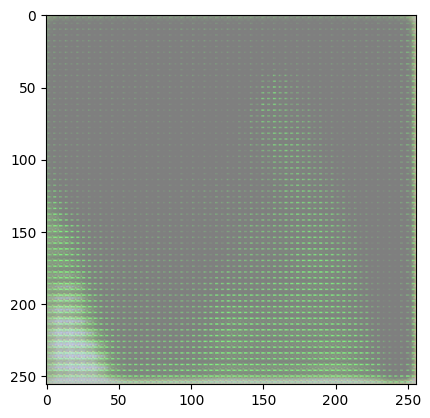

In [29]:
test_photo = photo_data.batch(1).take(1)
test_output = monet_generator.predict(test_photo)
plt.imshow(tf.cast(((test_output[0,:,:,:]+1)*127.5),tf.int32))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


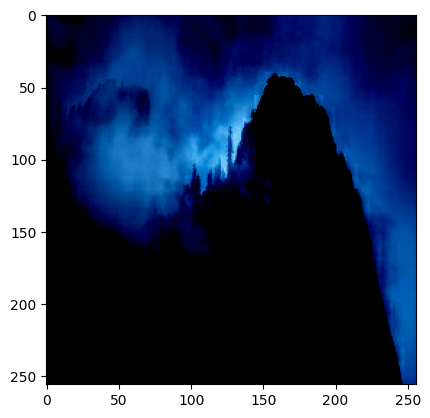

In [20]:
for photo in test_photo:
    plt.imshow(photo[0,:,:,:])
    plt.show()

In [28]:
#np.save(os.path.join(os.path.dirname(notebook_path), "save_models/11Normalization0.0002LearingRate44Kernel.npy"),history)
cycle_gan_model.save(os.path.join(os.path.dirname(notebook_path), "save_models/11Normalization0.0002LearingRate44Kernel.keras"))

/home/midelan/.local/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [ ]:
i = 0
for image in photo_data.batch(1):
    test_output = monet_generator.predict(image)
    test_output = test_output[0,:,:,:]*255
    test_output = test_output.astype(np.uint8)
    im = PIL.Image.fromarray(test_output)
    output_path = os.path.join(os.path.dirname(notebook_path), "RawExports/monet_gen_"+str(i)+".jpg")
    im.save(output_path)
    i += 1

In [63]:
def resize_to_150_percent(image):
    image = tf.image.resize(image, (384, 384))
    return image

def crop_to_at_least_100_percent(image):
    x_scale = random.randint(256,256*1.5)
    y_scale = random.randint(256,256*1.5)
    image = tf.image.random_crop(image, size=[x_scale, y_scale, 3])
    return image

def resize_to_100_percent(image):
    image = tf.image.resize(image, (256, 256))
    return image

In [70]:
augmented_monet_data = monet_data.map(tf.image.random_flip_left_right)
augmented_monet_data = augmented_monet_data.map(tf.image.random_flip_up_down)
augmented_monet_data = augmented_monet_data.map(resize_to_150_percent)
augmented_monet_data = augmented_monet_data.map(crop_to_at_least_100_percent)
augmented_monet_data = augmented_monet_data.map(resize_to_100_percent)

augmented_photo_data = photo_data.map(tf.image.random_flip_left_right)
augmented_photo_data = augmented_photo_data.map(tf.image.random_flip_up_down)
augmented_photo_data = augmented_photo_data.map(resize_to_150_percent)
augmented_photo_data = augmented_photo_data.map(crop_to_at_least_100_percent)
augmented_photo_data = augmented_photo_data.map(resize_to_100_percent)

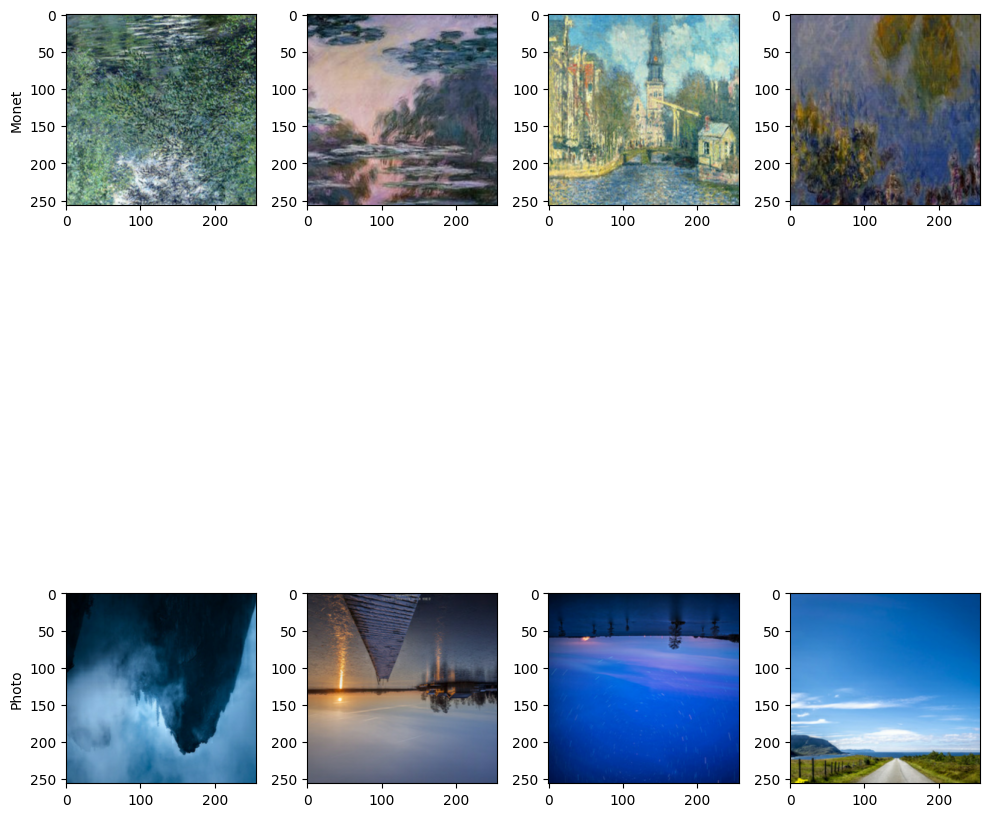

In [71]:
fig, axs = plt.subplots(2, 4, figsize=(10, 15))
for i, monets in enumerate(augmented_monet_data.batch(1).take(4)):
    monet = monets[0]
    axs[0, i].imshow(monet)
for i, photos in enumerate(augmented_photo_data.batch(1).take(4)):
    photo = photos[0]
    axs[1, i].imshow(photo)
for ax, row in zip(axs[:,0], ['Monet', 'Photo']):
        ax.set_ylabel(row)
fig.tight_layout()
plt.show()

In [72]:
def getLargerGenerator():
    input_image_generator = keras.Sequential(
        [
            keras.layers.InputLayer((256, 256, 3)),
            keras.layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(256, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(512, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(512, kernel_size=(4, 4), strides=(1, 1), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(512, kernel_size=(4, 4), strides=(1, 1), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(512, kernel_size=(4, 4), strides=(1, 1), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2DTranspose(512, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Dropout(0.2),
            keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Dropout(0.2),
            keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(3, kernel_size=(4, 4), strides=(1, 1), padding="same", activation="sigmoid"),
        ]
    )
    return input_image_generator

In [73]:
def getHighDropoutDiscriminator():
    input_image_discriminator = keras.Sequential(
        [
            keras.layers.InputLayer((256, 256, 3)),
            keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.7),
            keras.layers.Dense(64),
            keras.layers.Dropout(0.7),
            keras.layers.Dense(1, activation="sigmoid")
        ],
    )
    return input_image_discriminator

In [80]:
# Generators
monet_generator = getLargerGenerator()
photo_generator = getLargerGenerator()
monet_generator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
photo_generator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)

# Discriminators
monet_discriminator = getHighDropoutDiscriminator()
photo_discriminator = getHighDropoutDiscriminator()
monet_discriminator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
photo_discriminator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)

# CycleGan
cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

cycle_gan_model.compile(monet_generator_optimizer,
                  photo_generator_optimizer,
                  monet_discriminator_optimizer,
                  photo_discriminator_optimizer,
                  generator_loss,
                  discriminator_loss)
    
monet_data_temp = augmented_monet_data.shuffle(1024).batch(1)
photo_data_temp = augmented_photo_data.shuffle(1024).batch(1)

history = cycle_gan_model.fit(tf.data.Dataset.zip(monet_data_temp, photo_data_temp).shuffle(1028),
                        epochs=1,
                        verbose=1)

2024-10-14 05:32:05.438015: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/StatefulPartitionedCall/gradient_tape/sequential_10_3/leaky_re_lu_90_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/StatefulPartitionedCall/sequential_10_3/conv2d_68_1/add'.


300/300 ━━━━━━━━━━━━━━━━━━━━ 248s 806ms/step - monet_disc_loss: 0.8423 - monet_gen_loss: 16.2810 - photo_disc_loss: 0.5205 - photo_gen_loss: 40.5042


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


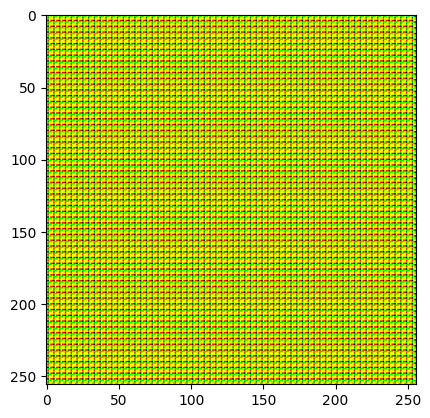

In [81]:
test_photo = photo_data.batch(1).take(1)
test_output = monet_generator.predict(test_photo)
plt.imshow(test_output[0,:,:,:])
plt.show()

In [85]:
data = [["Normalization Type", "Learning Rate", "Kernel", "Score"], 
        ["0...1", 0.0004, "(3,3)", "303.27"], 
        ["0...1", 0.0002, "(4,4)", "278.06"],
        ["-1...1", 0.0002, "(4,4)", "323.85"]]

print(tabulate(data, headers="firstrow")) 

Normalization Type      Learning Rate  Kernel      Score
--------------------  ---------------  --------  -------
0...1                          0.0004  (3,3)      303.27
0...1                          0.0002  (4,4)      278.06
-1...1                         0.0002  (4,4)      323.85


### Conclusion

Our results indicated that even a relatively simple model is capable of producing some results with a style transfer, especiall when they had a baseline image to start from. However we see that additional training is not really viable for this model, it needs additional work on the core components as it is very prone to collapsing when trained further.

This is a common known issue with GANs, and we suggest that this model could be improved with both additional data and a rework of the internal logic of the GAN. Additional research on this model by used for a dataset of many artists could produce better results as the discriminator may not have as much of an early advantage. Additionally our baseline GAN model has some commented code where we experimented with the possibility of declaring the generator or the discriminator the "victor" internally and only training the losing model until it caught up. This would ensure that neither model can get too far ahead of their counterpart and stop getting valuable information, however that attempt ended up being beyond the scope of time available for this project, so it would be another interesting research avenue.